<a href="https://colab.research.google.com/github/hagabbar/craft_prospect/blob/master/nn_for_key_assurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Networks for QRNG Quality Assurance

This is a script which will check for non-random subsequences 
from a quantum random number generator onboard a CubeSat. 
The code will first perform a benchmark suite of tests known 
as Diehard tests. The code will then use the results from these 
tests in order to properly evaluate the effectiveness of the  
neural network approach.

## Import required software packages

In [0]:
%matplotlib inline
# Magic command to use the inline backend for plotting
import numpy as np
from keras import Sequential
from keras.layers import LSTM, Dense, Embedding, SpatialDropout1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten, Activation
from keras.layers import LeakyReLU, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.optimizers import Adam
from keras.models import load_model
import matplotlib.pyplot as plt
from scipy import signal, interpolate, special
import subprocess
from sklearn import metrics
import os

## Define important global variables

Here we define important global variables which will be used 
through out the rest of the ipython notebook script. The first 
section describes variables which are pertinant to the 
model training/testing sections, whereas the second section 
determines plotting variables.

In [0]:
# Model variables
tot_num_samples = int(5e5)                          # total number of training/validation samples (50/50 split between rand and non-rand)
train_split = int(int(tot_num_samples/2) * 0.95)    # use 95% for training, 5% for validation
test_set_N = 1000                                   # number of samples in test set (total is twice this)
bitstream_len = 128                                 # length of train sample time series
batch_size = 64                                     # batch size (how many samples NN sees during each iteration)
bit_max_number = 4294967295                         # maximum allowed number in time series. This is dependent on bit size (in this case, 32bit)
ML_path = './results_files'                         # path to store results data files
run = '1'                                           # unique name of run
use_signals = ['sineGauss','sinewave','squarewave'] # user defined signal types to inject in noise 

# Plotting variables
snrs = [1e-2,2e-2,3e-2,4e-2,5e-2]                   # SNRs to inject signals at
runs = [1,1,1,1,1]                                  # runs to plot for ROC curves
thresholds = [0.1,0.01,0.001]                       # false alarm probability thresholds to compute ROC curves at
to_plot = [0,1,2,3]                                 # choose snrs to plot for TAP and FAP plot (1st result plot)

## Generate directories to store results and training/testing samples

This will generate two sets of directories. One set for each SNR value to contain 
the results of the diehard tests in the `diehard_results` directory. Also one for 
each SNR value to contain results of the machine learning algorithm in the directory 
defined by the `ML_path` variaable above.

In [4]:
# Save test sets for later use in results plots
if os.path.exists('{0}'.format('test_sets')):
    print('{0} already exists.'.format('test_sets'))
else:
    os.mkdir('{0}'.format('test_sets'))  
if os.path.exists('{0}/run{1}'.format('test_sets',run)):
    print('{0}/run{1} already exists'.format('test_sets',run))
else:
    os.mkdir('{0}/run{1}'.format('test_sets',run))

# iterate over all SNR injection levels
for j in range(len(snrs)):
    
    # Make diehard and ml results directories if they doesn't exist already
    if os.path.exists('diehard_results'):
        print('diehard_results dir already exits.')
    else:
        os.mkdir('diehard_results')
    if os.path.exists('diehard_results/snr%.8f' % snrs[j]):
        print('diehard_results/snr%.8f already exists.' % snrs[j])
    else:
        os.mkdir('diehard_results/snr%.8f' % snrs[j])
    if os.path.exists('{0}'.format(ML_path)):
        print('{0} already exists.'.format(ML_path))
    else:
        os.mkdir('{0}'.format(ML_path))
    if os.path.exists('{0}/SNR{1}'.format(ML_path,snrs[j])):
        print('{0}/SNR{1} already exists'.format(ML_path,snrs[j]))
    else:
        os.mkdir('{0}/SNR{1}'.format(ML_path,snrs[j]))
    if os.path.exists('{0}/SNR{1}/run{2}'.format(ML_path,snrs[j],run)):
        print('{0}/SNR{1}/run{2} already exists'.format(ML_path,snrs[j],run))
    else:
        os.mkdir('{0}/SNR{1}/run{2}'.format(ML_path,snrs[j],run))

diehard_results dir already exits.
./results_files already exists.
diehard_results dir already exits.
./results_files already exists.
diehard_results dir already exits.
./results_files already exists.
diehard_results dir already exits.
./results_files already exists.


## Make training and testing sets

In this section, we generate training and testing sets to be used for the machine learning 
algorithm. The total number of noise samples used  to make the validation and training sets 
is determined by the `tot_num_samples` variable. The total number of signal + noise samples are also determined by the `tot_num_samples` variable. Training samples make up 90% of this total, while validation 
makes up 10% of this total. 50% of the training and validation sets are made up of noise alone, the other 50% 
is made up of signal + noise signals. We employ 3 distinct classes of signal + noise signals (sinewave, sineGauss and square waves) evenly distributed accross both training and validation.

The total number of test samples to use is defined by the `test_set_N` variable. The same signal to noise split 
defined in the paragraph above, is also employed in the test set.

In [0]:
"""
Here we define some functions which will be used in the 
training/validation/testing generation procedure.
"""

def normalize(dataset):
    """Normalize given dataset to be between zero and one.
    """
    ((dataset - np.min(dataset)) / (np.max(dataset)-np.min(dataset)))
    return dataset

def make_sine_wave(bitstream_len):
    """Generate sine wave"""
    time = np.arange(0,bitstream_len,1)
    sinewave = (np.sin(time) + 1)
    return sinewave

def make_sineGauss_wave(bitstream_len):
    """Generate sine Gaussian wave"""
    time = np.linspace(-1, 1, bitstream_len, endpoint=False)
    sineGauss, q, e = signal.gausspulse(time, fc=5.0, retquad=True, retenv=True)
    sineGauss += 1
    return sineGauss

def make_square_wave(bitstream_len):
    """Generate square wave"""
    time = np.linspace(0, 1, bitstream_len, endpoint=False)
    squarewave = signal.square(2 * np.pi * 5 * time) + 1
    return squarewave

def make_set(set_split,use_signals,snrs,bitstream_len):
    """Generate training or validation set"""
    sample_set = []
    for i in range(set_split):
        signal_to_use = np.random.choice(use_signals)
        if signal_to_use == 'sineGauss':
            sample_set.append(np.random.choice(snrs) 
                              * normalize(make_sineGauss_wave(bitstream_len)) + 
                              np.random.uniform(low=0,high=(1.0),size=(1,bitstream_len)))
        elif signal_to_use == 'sinewave':
            sample_set.append(np.random.choice(snrs) 
                              * normalize(make_sine_wave(bitstream_len)) + 
                              np.random.uniform(low=0,high=(1.0),size=(1,bitstream_len)))
        elif signal_to_use == 'squarewave':
            sample_set.append(np.random.choice(snrs) 
                              * normalize(make_square_wave(bitstream_len)) + 
                              np.random.uniform(low=0,high=(1.0),size=(1,bitstream_len)))
    sample_set = np.array(sample_set).reshape(set_split,bitstream_len)
    return sample_set

In [26]:
"""
Make training, validation and testing sets.
"""
##################################################################
# Make noise-alone part of training, validation and testing sets #
##################################################################
# Generate random integer numbers from zero to maximum allowed number according to bit size
pseudo_rand_data_train = np.random.randint(low=0,high=bit_max_number,
                                           size=(train_split,bitstream_len),
                                           dtype=np.uint32)
pseudo_rand_data_val = np.random.randint(low=0,high=bit_max_number,
                                         size=(int(tot_num_samples/2) - train_split,bitstream_len),
                                         dtype=np.uint32)
pseudo_rand_labels_train = np.ones(train_split)
pseudo_rand_labels_val = np.ones(int(tot_num_samples/2) - train_split)

# Generate pseudo random numbers for machine learning test set
pseudo_rand_data_test = np.random.randint(low=0,high=bit_max_number,
                                          size=(len(snrs),test_set_N,
                                          bitstream_len),dtype=np.uint32)
pseudo_rand_labels_test = np.ones((len(snrs),int(test_set_N)))

###########################
# Make noisy training set #
###########################
noise_data_train = make_set(train_split,use_signals,snrs,bitstream_len)

# Make noisefree training set
noisefree_data_train = []
for i in range(train_split):
    signal_to_use = np.random.choice(use_signals)
    if signal_to_use == 'sinewave':
        noisefree_data_train.append(np.random.choice(snrs) * 
                                    normalize(make_sine_wave(bitstream_len)) + 
                                    np.zeros((1,bitstream_len)))
    elif signal_to_use == 'sineGauss':
        noisefree_data_train.append(np.random.choice(snrs) * 
                                    normalize(make_sineGauss_wave(bitstream_len)) + 
                                    np.zeros((1,bitstream_len)))
    elif signal_to_use == 'squarewave':
        noisefree_data_train.append(np.random.choice(snrs) * 
                                    normalize(make_square_wave(bitstream_len)) + 
                                    np.zeros((1,bitstream_len)))
noisefree_data_train = np.array(noisefree_data_train).reshape(train_split,bitstream_len)

# Normalize signal+noise to be between zero and 1
normalization_factor = np.max(noise_data_train)
noise_data_train /= normalization_factor
noisefree_data_train /= normalization_factor
# Bring signal back up to max value
noise_data_train *= bit_max_number
noisefree_data_train *= bit_max_number
# Make signal values be 32-bit integers
noise_data_train = np.uint32(noise_data_train)
noisefree_data_train = np.uint32(noisefree_data_train)

#######################
# Make validation set #
#######################
noise_data_val = make_set(int(tot_num_samples/2) - train_split,use_signals,
                          snrs,bitstream_len)

# normalize validation set by same factor as that used in training set
# make values on 32-bit scale
noise_data_val /= normalization_factor #np.max(noise_data_val)
noise_data_val *= bit_max_number
noise_data_val = np.uint32(noise_data_val)

#################
# Make test set #
#################
# Make numpy array to store test set (snr values, number of test samples, 
# length of test samples)
noise_data_test = np.zeros((len(snrs),test_set_N,bitstream_len))


for j in range(len(snrs)):
    for i in range(int(test_set_N)):
        signal_to_use = np.random.choice(use_signals)
        snr_to_use = snrs[j]
        if signal_to_use =='sinewave':
            noise_data_test[j,i,:] = (snr_to_use * 
                                      normalize(make_sine_wave(bitstream_len)) + 
                                      np.random.uniform(low=0,high=(1.0),size=(1,bitstream_len)))
        elif signal_to_use == 'sineGauss':
            noise_data_test[j,i,:] = (snr_to_use * 
                                      normalize(make_sineGauss_wave(bitstream_len)) + 
                                      np.random.uniform(low=0,high=(1.0),size=(1,bitstream_len)))
        elif signal_to_use == 'squarewave':
            noise_data_test[j,i,:] = (snr_to_use * 
                                      normalize(make_square_wave(bitstream_len)) + 
                                      np.random.uniform(low=0,high=(1.0),size=(1,bitstream_len)))

noise_data_test /= normalization_factor
noise_data_test *= bit_max_number
noise_data_test = np.uint32(noise_data_test)

########################################################################
# Make training, validation and test labels for signal + noise samples #
########################################################################
noise_labels_train = np.zeros(len(noise_data_train))
noise_labels_val = np.zeros(len(noise_data_val))
noise_labels_test = np.zeros((len(snrs),noise_data_test.shape[1]))

######################################################################
# Combine all data and labels into two arrays (X and Y respectively) #
######################################################################
X_train = np.concatenate((pseudo_rand_data_train,noise_data_train))
X_train_noisefree = np.concatenate((pseudo_rand_data_train,noisefree_data_train))
X_train_noisefree = X_train_noisefree.reshape(X_train_noisefree.shape[0],
                                              X_train_noisefree.shape[1],1)/bit_max_number
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)/bit_max_number
X_val = np.concatenate((pseudo_rand_data_val,noise_data_val))
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],1)/bit_max_number

X_test = np.concatenate((pseudo_rand_data_test,noise_data_test),axis=1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)/bit_max_number

Y_train = np.concatenate((pseudo_rand_labels_train,noise_labels_train))
Y_val = np.concatenate((pseudo_rand_labels_val,noise_labels_val))
Y_test = np.concatenate((pseudo_rand_labels_test,noise_labels_test),axis=1)

#########################
# Randomly shuffle sets #
#########################
#idx_shuffle = np.random.permutation(int(train_split*2))
#X_train = X_train[idx_shuffle,:]
#X_train_noisefree = X_train_noisefree[idx_shuffle,:]
#Y_train = Y_train[idx_shuffle]
#idx_shuffle = np.random.permutation(test_set_N*2)
#X_test = X_test[:,idx_shuffle,:,:]
#Y_test = Y_test[:,idx_shuffle]

###########################
# Save generated test set #
###########################
np.save('{0}/run{1}/test_set_val'.format('test_sets',run),X_test)
np.save('{0}/run{1}/test_set_labels'.format('test_sets',run),Y_test)

print('Made training, validation and testing sets')


Made training, validation and testing sets


## Show example of noise

Example of a normalized noise-alone signal 

This is a normalized noise-only signal


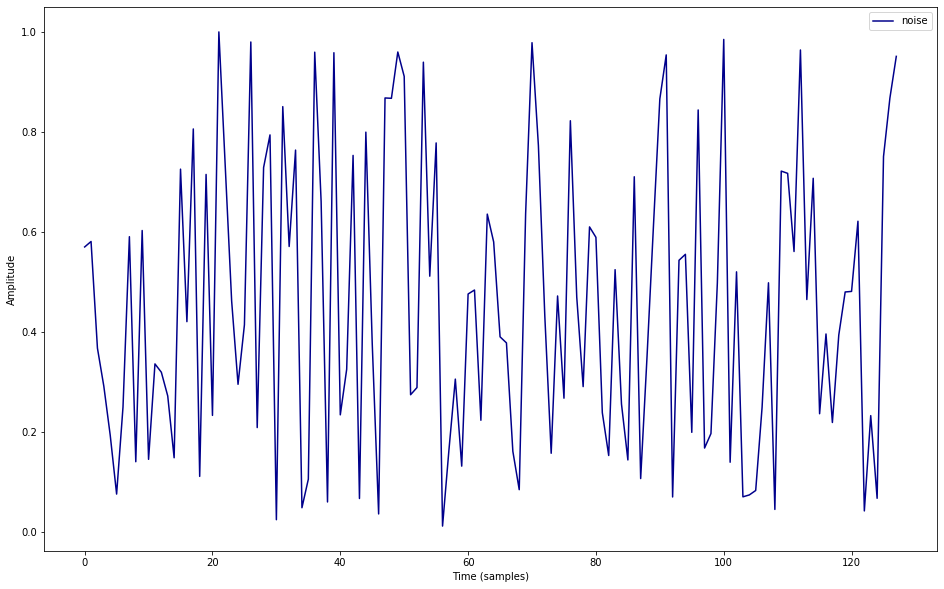

In [0]:
plt.close()
plt.figure(figsize=(16,10))
noise_example = np.random.uniform(low=0,high=(1.0),size=(bitstream_len))
plt.plot(noise_example, color='darkblue', label='noise') 
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
print('This is a normalized noise-only signal')

## Show example of signal + noise

Example of a normalized signal + noise signal.

This is a normalized signal+noise signal


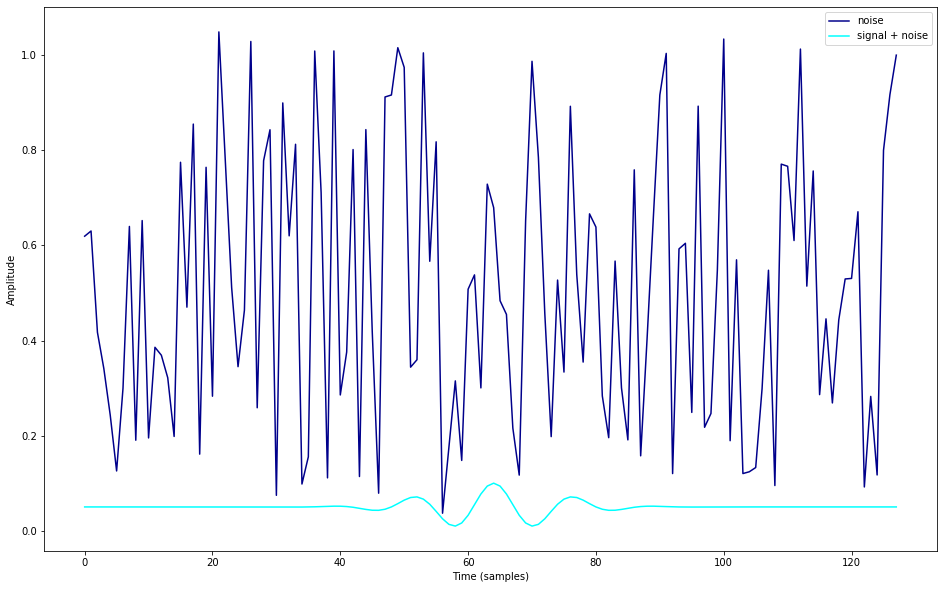

In [0]:
snr_idx = 4
signal_to_use = make_sineGauss_wave(bitstream_len)
plt.close()
plt.figure(figsize=(16,10))

signal_noisefree = snrs[snr_idx] * normalize(signal_to_use) + np.zeros((bitstream_len))

signal_plus_noise_ex = signal_noisefree + noise_example

plt.plot(signal_plus_noise_ex, color='darkblue', label='noise')
plt.plot(signal_noisefree, color='cyan', label='signal + noise')
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude')
plt.legend()
print('This is a normalized signal+noise signal')

# Apply Diehard Statistical Tests

Run Diehard tests on 2 * `test_set_N`, each with 
~1e7 elements in the time series. Diehard tests will output one of three values per 
each test sample PASS (1.0), WEAK PASS (0.5) and FAIL (0.0). Results accross multiple Diehard test for each test sample are averaged. You may choose which Diehard tests to run by editing the `diehard_tests` variable.

In [0]:
# List available Dieharder tests
!dieharder -l

In [0]:
# Choose diehard tests you'd like to use
diehard_tests = [4]#,6,8,9]#,10,11,15,202]

# Iterate over a predefined number of test samples
for j in range(len(snrs)):
    diehard_results = np.zeros((X_test.shape[0],len(diehard_tests)))
    for i in range(X_test.shape[1]):
    
        # If sample is noise-alone
        if Y_test[j,i] == 1:
            diehard_test_sample = np.random.randint(low=0,high=bit_max_number,
                                                    size=int(1e7),dtype=np.uint32)
        
        # If sample is signal + noise
        elif Y_test[j,i] == 0:
            signal_choice = np.random.choice(use_signals)
            if signal_choice == 'sineGauss':
                time = np.linspace(-1, 1, int(1e7), endpoint=False)
                sineGauss, q, e = signal.gausspulse(time, fc=5.0, retquad=True, 
                                                    retenv=True)
                diehard_test_noisefree_sample = sineGauss
            elif signal_choice == 'sinewave':
                time = np.arange(0,int(1e7),1)
                sinewave = (np.sin(time) + 1)
                diehard_test_noisefree_sample = sinewave
            elif signal_choice == 'squarewave':
                time = np.linspace(0, 1, int(1e7), endpoint=False)
                squarewave = signal.square(2 * np.pi * 5 * time)
                diehard_test_noisefree_sample = squarewave
            noise = np.random.uniform(low=0.0,high=1.0,size=int(1e7))
            diehard_test_sample = (snrs[j] * ((diehard_test_noisefree_sample - np.min(diehard_test_noisefree_sample)) / (np.max(diehard_test_noisefree_sample)-np.min(diehard_test_noisefree_sample))) + noise)
            norm = np.max(diehard_test_sample)
            diehard_test_sample /= norm
            diehard_test_sample *= bit_max_number
            diehard_test_sample = np.uint32(diehard_test_sample)
    
        # Save test sample to binary file format
        np.save('diehard_results/snr%.8f/test_sample%d' % (snrs[j],i), diehard_test_sample)
    
        # Run diehard tests on sample
        # Can specify to do all tests using -a option
        test_cnt = 0
        for k in diehard_tests:
            results_file_name = 'diehard_results/snr%.8f/test_sample%d.txt' % (snrs[j],i)
            diehard_input_file = 'diehard_results/snr%.8f/test_sample%d.npy' % (snrs[j],i)
            !dieharder -g 201 -d $k -f $diehard_input_file > $results_file_name
    
            # Save results for one test sample to total array
            test = open('diehard_results/snr%.8f/test_sample%d.txt' % (snrs[j],i), 'r+')
            t1 = test.readlines()
            line_cnt = 0
            for t1_line in t1:
                line_cnt +=1
                if line_cnt <= 8:
                    continue
                if line_cnt > 8:
                    if t1_line.split()[-1] == 'PASSED':
                        result_ele = 1.0
                    elif t1_line.split()[-1] == 'FAILED':
                        result_ele = 0.0
                    elif t1_line.split()[-1] == 'WEAK':
                        result_ele = 0.5
                    elif t1_line.split()[0] == '#':
                        continue
            diehard_results[i,test_cnt] = result_ele
            test_cnt += 1
            
#        results_file_name = 'diehard_results/snr%.8f/test_sample%d.txt' % (snrs[j],i)
#        diehard_input_file = 'diehard_results/snr%.8f/test_sample%d.npy' % (snrs[j],i)
#        !dieharder -g 201 -d 0 -f $diehard_input_file > $results_file_name

        # Make last element in each test sample equal to average result
        diehard_results[i,-1] = np.average(diehard_results[i,:])
    
        # remove saved test sample file
        os.remove(diehard_input_file)
        print('Completed Diehard tests on sample %d with snr %.8f' % (i+1,snrs[j]))
        print(diehard_results[i,-1])
        print(Y_test[i])
        
    # Save all Diehard results to one file
    np.save('{0}/SNR{1}/run{2}/diehard_preds.npy'.format(ML_path,snrs[j],run), diehard_results[:,-1])
    np.save('{0}/SNR{1}/run{2}/diehard_targets.npy'.format(ML_path,snrs[j],run), Y_test[j,:])

# Train and Test ML Model

## Option to load network model

In [0]:
model = load_model('trained_model/model.h5')

## Define network model

In [7]:
# Pure pytorch implementation

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = 'cuda' if torch.cuda.is_available() else 'cpu'

number_epochs = 10

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv1d(1, 32, 3).double()
        self.conv2 = nn.Conv1d(32, 64, 3).double()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(1920, 120).double()  # 6*6 from image dimension
        self.fc2 = nn.Linear(120, 84).double()
        self.fc3 = nn.Linear(84, 1).double()

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool1d(F.relu(self.conv1(x)), (2))
        # If the size is a square you can only specify a single number
        x = F.max_pool1d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
net.to(device)
print(net)

params = list(net.parameters())
#print(len(params))
#print(params[0].size())  # conv1's .weight

criterion = nn.MSELoss()

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001)

Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=1920, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)


In [17]:
running_loss = 0.0
number_epochs = 100
dset_train = TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
dataloader = DataLoader(dset_train, batch_size=batch_size,
                        shuffle=True)

# Iterate over entire training set
for epoch_num in range(number_epochs):
    for i_batch, sampled_batch in enumerate(dataloader):
        # in your training loop:
        if (train_split - (batch_size * i_batch)) < batch_size:
          break
        optimizer.zero_grad()   # zero the gradient buffers
        output = net(sampled_batch[0].reshape(batch_size,1,X_train.shape[1]).to(device))
        loss = criterion(output, sampled_batch[1].reshape(batch_size,1).to(device))
        loss.backward()
        optimizer.step()    # Does the update

    
    
    print('Training epoch %d/%d' % (epoch_num+1,number_epochs))
    # print statistics
#    running_loss += loss.item()
#    if i % int(X_train.shape[0]/batch_size) == (int(X_train.shape[0]/batch_size) - 1):    # print every 2000 mini-batches
#        print('loss: %.3f' %
#                (running_loss / 10))
#        running_loss = 0.0
#        epoch_num += 1
#        print('Training epoch %d/%d' % (epoch_num,number_epochs))

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Training epoch 1/100
Training epoch 2/100
Training epoch 3/100
Training epoch 4/100
Training epoch 5/100
Training epoch 6/100
Training epoch 7/100
Training epoch 8/100
Training epoch 9/100
Training epoch 10/100
Training epoch 11/100
Training epoch 12/100
Training epoch 13/100
Training epoch 14/100
Training epoch 15/100
Training epoch 16/100
Training epoch 17/100
Training epoch 18/100
Training epoch 19/100
Training epoch 20/100
Training epoch 21/100
Training epoch 22/100
Training epoch 23/100
Training epoch 24/100
Training epoch 25/100
Training epoch 26/100
Training epoch 27/100
Training epoch 28/100
Training epoch 29/100
Training epoch 30/100
Training epoch 31/100
Training epoch 32/100
Training epoch 33/100
Training epoch 34/100
Training epoch 35/100
Training epoch 36/100
Training epoch 37/100
Training epoch 38/100
Training epoch 39/100
Training epoch 40/100
Training epoch 41/100
Training epoch 42/100
Training epoch 43/100
Training epoch 44/100
Training epoch 45/100
Training epoch 46/1

KeyboardInterrupt: ignored

In [18]:
for i in range(len(snrs)):
    # Make predictions on Testing set
    preds = net(torch.tensor(X_test[::-1][i,:,:,:]).reshape(X_test[i].shape[0],
                                                            1,X_test[i].shape[1]).to(device))
    targets = Y_test[::-1][i,:]
    
    # Save model predictions
    np.save('{0}/SNR{1}/run{2}/targets.npy'.format(ML_path,snrs[i],run), targets)
    np.save('{0}/SNR{1}/run{2}/preds.npy'.format(ML_path,snrs[i],run), preds.cpu().detach().numpy().squeeze())

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
# Pure Keras implementation
lstm_out = 100
batch_size = 64

model = Sequential()

#model.add(Conv1D(300,
#                 3,
#                 padding='valid',
#                 activation='relu',
#                 strides=1,
#                 input_shape=(bitstream_len,1)))
#model.add(Conv1D(250,
#                 3,
#                 padding='valid',
#                 activation='relu',
#                 strides=1))

# we use max pooling:
#model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
#model.add(Dense(250))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
#model.add(Dense(1))
#model.add(Activation('sigmoid'))


model.add(Conv1D(filters=16, kernel_size=3, activation='elu', input_shape=(bitstream_len,1),padding='valid'))
#model.add(LeakyReLU())
model.add(Conv1D(filters=16, kernel_size=3, strides=2, activation='elu',padding='valid'))
#model.add(LeakyReLU())
model.add(Conv1D(filters=32, kernel_size=3, activation='elu',padding='valid'))
#model.add(LeakyReLU())
model.add(Conv1D(filters=32, kernel_size=3, strides=2, activation='elu',padding='valid'))
#model.add(LeakyReLU())
model.add(Conv1D(filters=64, kernel_size=3, activation='elu',padding='valid'))
#model.add(LeakyReLU())
model.add(Conv1D(filters=64, kernel_size=3, strides=2, activation='elu',padding='valid'))
#model.add(LeakyReLU())
model.add(Dropout(0.2))
model.add(GlobalAveragePooling1D())
#model.add(Flatten())
model.add(Dense(128, activation='elu'))
#model.add(LeakyReLU())
model.add(Dense(128, activation='elu'))
#model.add(LeakyReLU())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


"""
# Simple fully-connected network
model.add(Dense(512, input_dim=bitstream_len))
model.add(LeakyReLU())
model.add(Dense(256))
model.add(LeakyReLU())
model.add(Dense(128))
model.add(LeakyReLU())
model.add(Dense(64))
model.add(LeakyReLU())
model.add(Dense(1, activation='sigmoid'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='mean_squared_error', optimizer=adam, metrics=['accuracy'])
"""
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_13 (Conv1D)           (None, 126, 16)           64        
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 62, 16)            784       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 60, 32)            1568      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 29, 32)            3104      
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 27, 64)            6208      
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 13, 64)            12352     
_________________________________________________________________
dropout_3 (Dropout)          (None, 13, 64)            0         
__________

## Train and save model

In [0]:
#model.fit(X_train.reshape(X_train.shape[0],X_train.shape[1]), Y_train, validation_data=(X_val.reshape(X_val.shape[0],X_val.shape[1]), Y_val), batch_size = batch_size, epochs = 10,  verbose = 1)
model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size = batch_size, epochs = 10,  verbose = 1)

Train on 95000 samples, validate on 5000 samples
Epoch 1/10
95000/95000 [==============================] - 13s 139us/step - loss: 0.1856 - acc: 0.9250 - val_loss: 0.1600 - val_acc: 0.9366
Epoch 2/10
95000/95000 [==============================] - 13s 138us/step - loss: 0.1743 - acc: 0.9306 - val_loss: 0.1659 - val_acc: 0.9342
Epoch 3/10
95000/95000 [==============================] - 13s 139us/step - loss: 0.1615 - acc: 0.9356 - val_loss: 0.1614 - val_acc: 0.9332
Epoch 4/10
95000/95000 [==============================] - 13s 140us/step - loss: 0.1567 - acc: 0.9378 - val_loss: 0.1617 - val_acc: 0.9354
Epoch 5/10
95000/95000 [==============================] - 13s 142us/step - loss: 0.1511 - acc: 0.9400 - val_loss: 0.1410 - val_acc: 0.9448
Epoch 6/10
95000/95000 [==============================] - 13s 142us/step - loss: 0.1433 - acc: 0.9429 - val_loss: 0.1495 - val_acc: 0.9388
Epoch 7/10
95000/95000 [==============================] - 13s 136us/step - loss: 0.1383 - acc: 0.9450 - val_loss: 0.1

In [0]:
model.save('trained_model/model.h5')

## Evaluate model

Evaluate the accuracy on a unique test set which has 
not been used during either the training or the validation phase. 
Only look at the first N elements of sequences (same length as that 
used during training).

In [0]:
for i in range(len(snrs)):
    #score,acc = model.evaluate(X_test[::-1][i].reshape(X_test[i].shape[0],X_test[i].shape[1]),Y_test[::-1][i],batch_size=batch_size,verbose=2)
    score,acc = model.evaluate(X_test[::-1][i,:,:,:],Y_test[::-1][i],batch_size=batch_size,verbose=2)
    print("Score: %.2f at snr %.8f" % (score,snrs[i]))
    print("Validation Accuracy: %.2f at snr %.8f" % (acc,snrs[i]))
    
    # Make predictions
    #preds = model.predict(X_test[::-1][i].reshape(X_test[i].shape[0],X_test[i].shape[1]))
    preds = model.predict(X_test[::-1][i,:,:,:])
    targets = Y_test[::-1][i,:]

    # Save model predictions
    np.save('{0}/SNR{1}/run{2}/targets.npy'.format(ML_path,snrs[i],run), targets)
    np.save('{0}/SNR{1}/run{2}/preds.npy'.format(ML_path,snrs[i],run), preds.reshape(preds.shape[0]))

Score: 0.04 at snr 0.01000000
Validation Accuracy: 0.98 at snr 0.01000000
Score: 0.04 at snr 0.02000000
Validation Accuracy: 0.99 at snr 0.02000000
Score: 0.08 at snr 0.03000000
Validation Accuracy: 0.97 at snr 0.03000000
Score: 0.17 at snr 0.04000000
Validation Accuracy: 0.93 at snr 0.04000000
Score: 0.29 at snr 0.05000000
Validation Accuracy: 0.88 at snr 0.05000000


In [0]:
## Results plots

Plots illustrating the robustness of the model.

In [0]:
def CNN_ROC(ml_path, snr, run, network_type, num_test):
    """
    calculate roc curve for machine learning results
    """
    if network_type == 'ML':
        targets = np.load('{0}/SNR{1}/run{2}/targets.npy'.format(ml_path,snr,run))
        preds = np.load('{0}/SNR{1}/run{2}/preds.npy'.format(ml_path,snr,run))
        targets, preds = targets[:], preds[:]
    elif network_type == 'diehard':
        targets = np.load('{0}/SNR{1}/run{2}/diehard_targets.npy'.format(ml_path,snr,run))
        preds = np.load('{0}/SNR{1}/run{2}/diehard_preds.npy'.format(ml_path,snr,run))
        targets, preds = targets[:], preds[:]
    assert len(preds) == len(targets)
    FDP, TDP, _ = metrics.roc_curve(targets, preds)
    FDP_error = [sigma(len(targets)/2., t) for t in FDP]
    TDP_error = [sigma(len(targets)/2., t) for t in TDP]
    return FDP, TDP, FDP_error, TDP_error

In [0]:
def sigma(n, tp):
    """ Computes standard deviation
    :param tp:
    :param n:
    :return:
    """
    return np.sqrt(tp*(1.-tp)/n)

In [0]:
def accuracy(FDP,TDP,TDP_error, threshold):
    """
    calculate accuracy(efficiency) given fdp and tdp
    """
    fx = interpolate.interp1d(FDP,TDP)
    fx_e_neg = interpolate.interp1d(FDP,TDP-TDP_error)
    fx_e_pos = interpolate.interp1d(FDP,TDP+TDP_error)
    acc = fx(threshold)
    acc_e_neg = fx_e_neg(threshold)
    acc_e_pos = fx_e_pos(threshold)
    return acc, acc_e_neg, acc_e_pos

In [0]:
def interp_sig(snr, tdp, threshold, c, snrs):
    """
    use spline interpolation to fit a line
    uses sigmoid to map (0,1) to (-inf, inf) and vice-versa
    :param snr:
    :param rho:
    :param threshold:
    :param snrs: list of snrs
    :return:
    """
    # assume start with NaN
    flag = True
    while flag:
        snr_new, tdp_new = interp_loop(snr, tdp, threshold, c, snrs)
        if not np.isnan(tdp_new).any():
            flag = False
        else:
            snr = snr[1:]
            tdp = tdp[1:]

    if np.isnan(tdp_new).any():
        print('Failed to avoid NaNs')

    return snr_new, tdp_new

In [0]:
def interp_loop(snr, tdp, threshold, c, snrs):
    """
    function to loop over to peform spline interpolation
    :param snr:
    :param rho:
    :param threshold:
    :param c: fuzzfactor
    :param snrs: list of snr values
    """
    # find min value
    min_tdp = np.min(tdp)
    # take log of data to avoid negative values
    tmp_tdp = special.logit(tdp - min_tdp + c)
    # interpolate with spline interpolation
    print(snr,tmp_tdp)
    tck = interpolate.splrep(snr, tmp_tdp)
    # new x and y values
    snr_new = np.linspace(snrs[0], snrs[-1], 1e3)
    tmp_tdp_new = interpolate.splev(snr_new, tck, der=0)
    # return to linear space
    tdp_new = special.expit(tmp_tdp_new) + min_tdp - c

    return snr_new, tdp_new

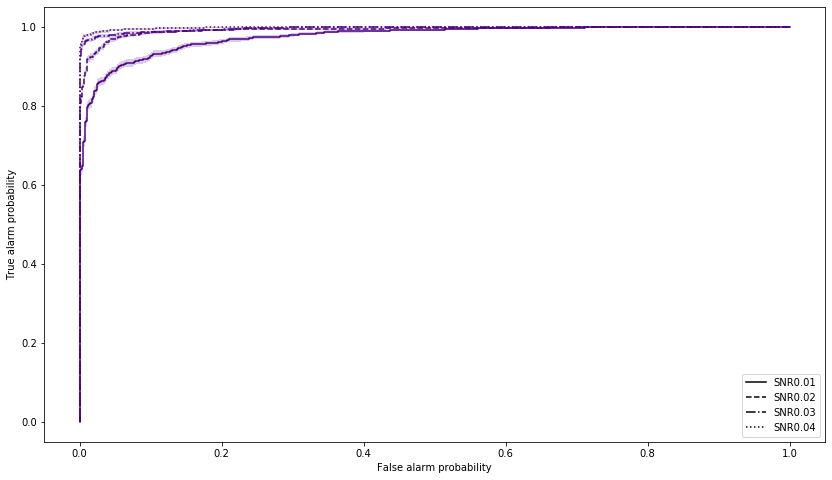

In [19]:
# Make TAP/FAP figure

# empty lists to populate
MF_ROCs = []
CNN_ROCs = []
MF_acc = []
CNN_acc = []

# plot roc curves
fig1 = plt.figure(figsize=(14,8))
ax1 = fig1.add_subplot(1, 1, 1)
ax1.set_rasterization_zorder(1)

# colours and line styles for plots
colours = ['indigo', 'c', 'darkorange', 'indigo', 'c', 'darkorange', 'indigo', 'c', 'darkorange']
linestyles = ['-', '--', '-.', ':']

lineArtist = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-')
dashArtist = plt.Line2D((0, 1), (0, 0), color='k', linestyle='--')
dashdotArtist = plt.Line2D((0, 1), (0, 0), color='k', linestyle='-.')
dotArtist = plt.Line2D((0,1), (0, 0), color = 'k', linestyle = ':')
c1Artist = plt.Line2D((0, 1), (0, 0), color=colours[0], linestyle='', marker='o')
c2Artist = plt.Line2D((0, 1), (0, 0), color=colours[1], linestyle='', marker='o')
c3Artist = plt.Line2D((0, 1), (0, 0), color=colours[2], linestyle='', marker='o')

# handles for different plots
handles = [lineArtist, dashArtist, dashdotArtist,dotArtist]
acc_handles = [c1Artist, c2Artist, lineArtist, dashArtist, dashdotArtist]
ROC_labels = ['SNR0.01', 'SNR0.02', 'SNR0.03', 'SNR0.04']
acc_labels = ['CNN', 'Diehard', 'FAP = 0.1', 'FAP = 0.01', 'FAP = 0.001']

# calcualte ROC curves and accuracy
for snr, run in zip(snrs, runs):
    FDP, TDP, FDP_error, TDP_error = CNN_ROC(ML_path, snr, run, 'ML', test_set_N)
    CNN_ROCs.append([FDP, TDP, FDP_error, TDP_error])
    CNN_acc.append([accuracy(FDP, TDP, TDP_error, t) for t in thresholds])
    
#    FDP, TDP, FDP_error, TDP_error = CNN_ROC(ML_path, snr, run, 'diehard', test_set_N)
#    MF_ROCs.append([FDP, TDP, FDP_error, TDP_error])
#    MF_acc.append([accuracy(FDP, TDP, TDP_error, t) for t in thresholds])

for i, d in enumerate([CNN_ROCs[n] for n in to_plot]):
    ax1.plot(d[0], d[1], c=colours[0], linestyle=linestyles[i], label='CNN snr {0}'.format(snrs[i]))
    ax1.fill_between(d[0], d[1]+d[3], d[1]-d[3], alpha=0.2, facecolor=colours[0], zorder=0)
    
#for i, d in enumerate([MF_ROCs[n] for n in to_plot]):
#    ax1.plot(d[0], d[1], c=colours[1], linestyle=linestyles[i], label='Diehard snr {0}'.format(snrs[i]))
#    ax1.fill_between(d[0], d[1]+d[3], d[1]-d[3], alpha=0.2, facecolor=colours[1], zorder=0)
    
ax1.set_xlabel('False alarm probability')
ax1.set_ylabel('True alarm probability')
#ax1.set_xscale('log')
#ax1.set_yscale('log')
#ax1.set_xlim(1e-4, 1)
#ax1.set_ylim(1e-4, 1)
ax1.legend(handles, ROC_labels)

[0.01, 0.02, 0.03, 0.04, 0.05] [-7.60040233 -2.74172747 -2.74270445 -2.61110975 -2.57119917]
[0.01, 0.02, 0.03, 0.04, 0.05] [-7.60040233 -2.04557763 -1.56801187 -1.48615196 -1.40515099]
[0.01, 0.02, 0.03, 0.04, 0.05] [-7.60040233 -1.57503357 -0.89295692 -0.76990341 -0.66106685]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


(0, 1)

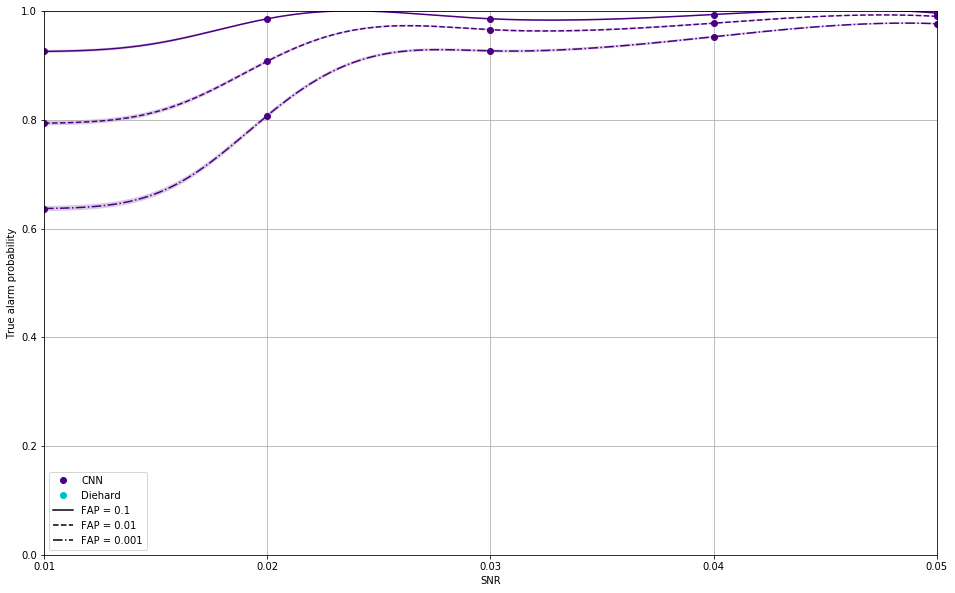

In [20]:
# Make efficiency curve
fig2 = plt.figure(figsize=(16,10))
ax2 = fig2.add_subplot(1, 1, 1, )
ax2.set_rasterization_zorder(1)

# fuzz factors for each thresholds
ffs = [0.5e-3, 0.5e-3, 0.5e-3]

for i in range(len(thresholds)):
    # points to plot
    cnn = np.asarray([a[i][0] for a in CNN_acc])
    # line fit
    snr_cnn, eff_cnn = interp_sig(snrs, cnn, thresholds[i], ffs[i], snrs)
    
    # points to plot
#    mf = np.asarray([a[i][0] for a in MF_acc])
    # line fit
#    snr_mf, eff_mf = interp_sig(snrs, mf, thresholds[i], ffs[1], snrs)

    # errors
    d_eff_cnn = [sigma(1e4, e) for e in eff_cnn]
#    d_eff_mf = [sigma(1e4, e) for e in eff_mf]

    # plot points for cnn
    ax2.plot(snrs, cnn, c=colours[0], marker = 'o', linestyle='')
    # plot line fit for cnn
    ax2.plot(snr_cnn, eff_cnn, c=colours[0], linestyle=linestyles[i])
    # plot error region for cnn
    ax2.fill_between(snr_cnn, eff_cnn - d_eff_cnn , eff_cnn + d_eff_cnn, facecolor=colours[0], alpha=0.2, zorder=0)

    
    # plot points for mf
#    ax2.plot(snrs, mf, c=colours[1], marker = 'o', linestyle='',)
    # plot line fit for mf
#    ax2.plot(snr_mf, eff_mf, c=colours[1], linestyle=linestyles[i])
    # plot error region for mf
#    ax2.fill_between(snr_mf, eff_mf - d_eff_mf, eff_mf + d_eff_mf, facecolor=colours[1], alpha=0.2, zorder=0)
    

#ax2.legend(acc_handles, acc_labels)
ax2.legend(acc_handles, acc_labels)
ax2.set_xticks(snrs)
ax2.grid()
ax2.set_xlabel('SNR')
ax2.set_ylabel('True alarm probability')
ax2.set_xlim(snrs[0], snrs[-1])
ax2.set_ylim(0, 1)